# Writing Custom `Datasets`, `DataLoaders` and `Transforms` - Face Detection Example

A lot of effort in solving any machine learning problem goes in to preparing the **data**. PyTorch provides many tools to make data-loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non-trivial dataset.

## Requirements:

1. `scikit-image`: For image io and transforms
2. `pandas`: For easier csv parsing

In [ ]:
from google.colab import drive
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# mount project dir
drive.mount('/content/gdrive')
# !ls '/content/gdrive/My Drive/'
path = '/content/gdrive/MyDrive/LR Research/Coding/notebooks-Colab/'
project_path = path + 'face_landmarks/'
face_path = project_path + 'faces/'

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

Mounted at /content/gdrive


In [ ]:
# read the CSV and get annotations in an (N, 2) array where N
# is the number of landmarks.
landmarks_frame = pd.read_csv(face_path + 'face_landmarks.csv')
print(landmarks_frame, '\n')

# pick up a face
n = 60
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]

#landmarks = landmarks.to_numpy()
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('image name: {}'.format(img_name))
print('landmarks shape: {}'.format(landmarks.shape))
print('first 4 landmarks: {}'.format(landmarks[:4]))


                           image_name  part_0_x  ...  part_67_x  part_67_y
0                 0805personali01.jpg        27  ...         84        134
1           1084239450_e76e00b7e7.jpg        70  ...        128        312
2                  10comm-decarlo.jpg        66  ...        116        164
3            110276240_bec305da91.jpg        42  ...        125        209
4                      1198_0_861.jpg       138  ...        265        516
..                                ...       ...  ...        ...        ...
64                    matt-mathes.jpg        85  ...        141        235
65                       person-7.jpg        32  ...         69         99
66                         person.jpg        78  ...        109        121
67  person_TjahjonoDGondhowiardjo.jpg        41  ...         77        128
68                    personalpic.jpg        40  ...         68        164

[69 rows x 137 columns] 

image name: 96063776_bdb3617b64.jpg
landmarks shape: (68, 2)
first 4 land

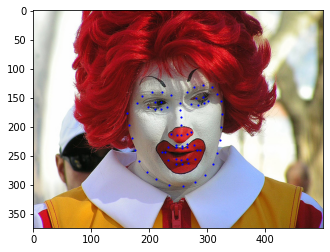

In [ ]:
# a simple helper function to show an image and its landmarks
def show_landmarks(image, landmarks):
    """show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, marker='.', c='b')
    plt.pause(0.001) # pause a bit so that plots are updated

show_landmarks(io.imread(face_path + img_name), landmarks)

## Dataset class

`torch.utils.data.Dataset` is an abstract class representing a dataset. your custom dataset should 
inherit `Dataset` and override the 
following methods:
+ `__len__` so that `len(dataset)` returns the size of the dataset.
+ `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$th sample.

Let's create a dataset class for our face landmarks dataset. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are note stored in the memory at once but read as required.

Samples of our dataset will be a dict `{'image': image, 'landmarks': landmarks}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample.


In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): path to the csv file with annotations.
            root_dir (string): directory with all the images.
            transform (callable, optional): optional transform
                to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        # applying transform if transform is not None
        if self.transform:
            sample = self.transform(sample)
        
        return sample

0 (333, 500, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (332, 500, 3) (68, 2)


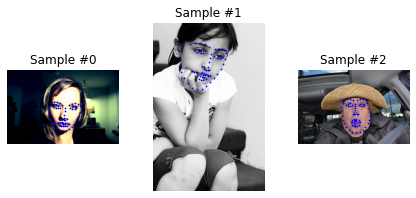

In [ ]:
# insatantiate the FaceLandmarksDataset and iterate thorugh the data samples.
# print the size of first 4 samples and show their landmarks.
face_dataset = FaceLandmarksDataset(csv_file=face_path + 'face_landmarks.csv',
                                    root_dir=face_path)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i+32]
    print(i, sample['image'].shape, sample['landmarks'].shape)

    num_subplot = 3
    ax = plt.subplot(1, num_subplot, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    ax.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], s=2, marker='.', c='b')

    if i == num_subplot - 1:
        plt.show()
        break

## Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the image of a fixed size. Therefore, we will need to write some preprocessing code. Let's create three transforms:

+ `Rescale`: to scale the image
+ `RandomCrop`: to crop from image randomly. This is data augmentation.
+ `ToTensor`: to convert the numpy images to torch images (**we need to swap axes**).

We will write them as *callable classes* instead of simple functions so that parameters of the transform need not to be passed everytime it's called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:

```python
tsfm = Transform(params) # callable object like a function
transformed_sample = tsfm(sample)
```

Observe below how these transforms had to be applied **both** on the image and landmarks.

In [ ]:
class Rescale():
    """Rescale the image in a sample to a given size."""
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Desired output size.
            If tuple, output is matched to output_size. If int,
            smaller of image edges is matched to output_size keeping
            aspect ratio the same.
        """
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        rescaled_img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        rescaled_landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': rescaled_img, 'landmarks':rescaled_landmarks}


class RandomCrop():
    """Crop randomly the image in a sample"""
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Desired output size. if int,
            square crop is made.
        """
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        cropped_image = image[top: top + new_h,
                      left: left + new_w]
        cropped_landmarks = landmarks - [left, top]

        return {'image': cropped_image, 'landmarks': cropped_landmarks}

class ToTensor():
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2,0,1))

        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose Transforms

Let's say we want to rescale the shorter side if the image to 256 and then randomly crop a square of size 224 from it. i.e. we want to compose `Rescale` and `RandomCrop` transforms. `torchvision.transforms.Compose` is a simple callable class which allows us to do this.

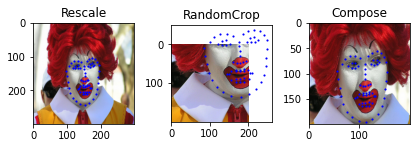

In [ ]:
scale = Rescale((300, 300))
crop = RandomCrop(200)
composed = transforms.Compose([scale, crop])

# apply each of the above transforms on sample
fig = plt.figure()
sample = face_dataset[60]

for i, tsfm in enumerate([scale, crop, composed]):
    transformed_sample = tsfm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfm).__name__)
    ax.imshow(transformed_sample['image'])
    landmarks = transformed_sample['landmarks']
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=5, marker='.', c='b')

plt.show()

## Iterating through the dataset

Let's put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

 1. An image is read from the file on the fly
 2. Transforms are applied on the read image
 3. Since one of the transforms is random, data is augmentated on sampling

In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file=face_path + 'face_landmarks.csv',
                                           root_dir=face_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple `for` loop to iterate over the data. In particular, we are missing out on:

+ Batching the data
+ Shuffling the data
+ Load the data in parallel using `multiprocessing` workers

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the sample need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


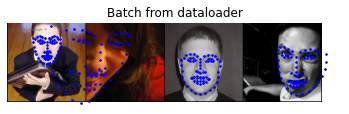

In [ ]:
dataloader = DataLoader(transformed_dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=0)

# helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples"""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2) # or size(3)
    grid_padding = 2 # default padding = 2

    grid = utils.make_grid(images_batch, padding=grid_padding)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0] + i * im_size + 
                    (i + 1) * grid_padding, 
                    landmarks_batch[i, :, 1] + grid_padding,
                    s=10,
                    marker='.',
                    c='b')
        
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())

    # observe 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Conclusion

In this example, we implemented our own `FaceLandmarksDataset`, which returns a `dict` sample by rewriting `__getitem__` method. In torchvision datasets like `datasets.CIFAR10`, this method will return `img, target` in a separate way, which is different from this demo, keep that in mind.

### What I have learned:

1. Implement your own dataset by subclassing `torch.utils.data.Dataset` class, and rewrite `__len__()` & `__getitem__()` method. Leave `transform` as an interface for potential transform operations.
2. Write transform as `class`es, and implement the `__call__()` method to make it excute like a method. Self-written transform classes can be composed by `torchvision.transforms.Compose()` method.
3. To load and iterate your dataset, it's better to use `torch.utils.data.DataLoader`. It's *iterable* and capable of automatic *shuffle* and *batch-sampling*.